In [111]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from methods import get_autoregrmatrix, get_so2_index, get_10pm_index, get_25pm_index, get_o3_index, get_no2_index, get_co_index, process_data

import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import pandas.tseries.offsets as ofs
import scipy as sc 

from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

%matplotlib inline 

In [4]:
main_path = "data/"
dirs = ["CO", "NO2", "O3", "PM10", "PM2.5", "SO2"]

In [5]:
processed_dfs = {}
for dir in dirs:
    df, validated_info = process_data(main_path, dir)
    processed_dfs[dir] = df
    print(f"{dir} - {validated_info}")

CO - Количество ошибочных значений: 4642 в процентном отношении 3.31
NO2 - Количество ошибочных значений: 19470 в процентном отношении 2.28
O3 - Количество ошибочных значений: 19807 в процентном отношении 8.37
PM10 - Количество ошибочных значений: 8467 в процентном отношении 1.31
PM2.5 - Количество ошибочных значений: 2626 в процентном отношении 2.6
SO2 - Количество ошибочных значений: 71863 в процентном отношении 54.66


In [14]:
# Соберём в один df и удалим дублирующие строки
marked_by_pollutant_data = []
for pollutant, pollutant_df in processed_dfs.items():
    marked_by_pollutant_data.append(pollutant_df)

marked_df = pd.concat(marked_by_pollutant_data, axis=1)
marked_df["Date"] = marked_df.iloc[:, 0]

duplicate_cols = marked_df.columns[marked_df.columns.duplicated()]
marked_df.drop(columns=duplicate_cols, inplace=True)

In [18]:
# Найдём индекс по каждому загрязнителю
marked_df["SO2_index"] = marked_df["SO2_Concentration"].apply(lambda x: get_so2_index(x))
marked_df["PM10_index"] = marked_df["PM10_Concentration"].apply(lambda x: get_10pm_index(x))
marked_df["PM2.5_index"] = marked_df["PM2.5_Concentration"].apply(lambda x: get_25pm_index(x))
marked_df["O3_index"] = marked_df["O3_Concentration"].apply(lambda x: get_o3_index(x))
marked_df["NO2_index"] = marked_df["NO2_Concentration"].apply(lambda x: get_no2_index(x))
marked_df["CO_index"] = marked_df["CO_Concentration"].apply(lambda x: get_co_index(x))

In [193]:
# Найдём общий индекс воздуха
marked_df["aqi_index"] = marked_df[["SO2_index", "PM10_index", "PM2.5_index", "O3_index", "NO2_index", "CO_index"]].max(axis=1).astype(int)

In [220]:
index_df = marked_df[["aqi_index", 'Date']]
index_df = index_df.set_index('Date').sort_index()

In [229]:
start_train = pd.to_datetime('2013-01-01').date()
end_train = pd.to_datetime('2018-01-01').date()

start_test = pd.to_datetime('2018-01-02').date()
end_test = pd.to_datetime('2020-12-31').date()

x_train = index_df['aqi_index'][start_train:end_train]
x_test =  index_df['aqi_index'][start_test:end_test]

Baseline

In [260]:
K = 10 # количество регрессоров
h = 5 # горизонn прогнозирования

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

In [266]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
linear_regression_predict = linear_regression.predict(X_test)

In [267]:
f'Train score:{linear_regression.score(X_train, y_train)}, Test score {linear_regression.score(X_test, y_test)}'

'Train score:0.3730154369690224, Test score 0.4607371635417755'

<AxesSubplot: xlabel='Date'>

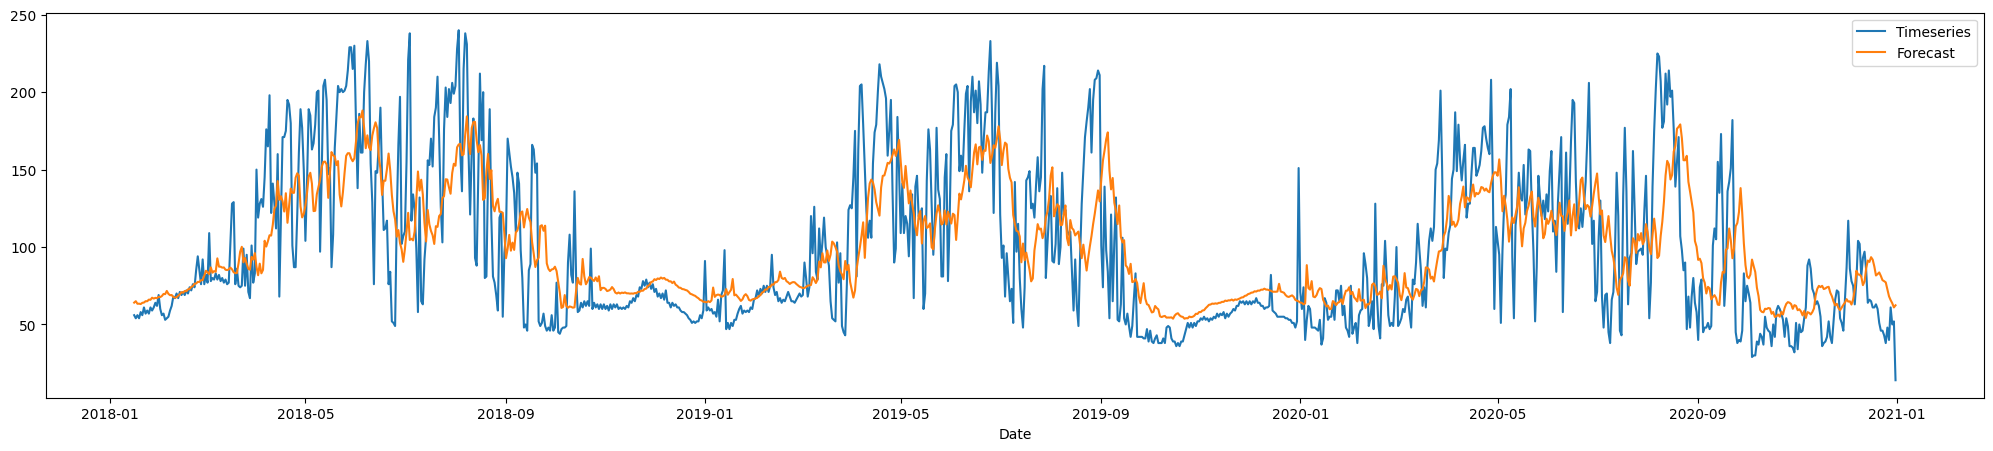

In [268]:
pd.DataFrame({'Timeseries':y_test, 'Forecast': linear_regression_predict}).plot(figsize = (25,5))